# Todo list:

1. Calibrate the DC value of the accelerometer
1. Convert units to m/s^2 everywhere
2. Calibrate the gyro tilt
3. measure covariances of all the sensors
4. Understand why the MARG is worse than IMU

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import csv
import numpy as np
from scipy import fft
from numpy import exp,sin,cos,pi
from numpy.linalg import norm
#from pyquaternion import Quaternion 
from scipy.optimize import minimize

from utils import *

import ahrs
from ahrs import Quaternion
from geomag.geomag import GeoMag


In [ ]:
## Geomagnetic data
## coordinates at hillegas x parker in berkeley
lat=37.864
lon=-122.256
gm=GeoMag().GeoMag(lat,lon)
gm.dec
gm.dip

In [ ]:
## Read in the data
raw_dat=load_endaq_log("data/accel_cal_")

#Pull out the magnetometer data in numpy form
dfMag=raw_dat['mag']
mag=dfMag.to_numpy()
# Get the magnetometer time series in seconds
ts=dfMag.index.to_numpy(dtype=np.float32)/1e9
ts=ts-ts[0]

# Synch the gyro to the magnetometer, convert to radians/s
gyro=(pi/180)*synchronize_series(raw_dat['gyro'],ref=dfMag).to_numpy()

#Sync the accelerometer to the gyro
#the 8g accelerometer is by far the best.
acc=   synchronize_series(raw_dat['acc8'],ref=dfMag).to_numpy()
#accIMU= synchronize_series(raw_dat['accIMU'],ref=dfMag).to_numpy()
#acc16=  synchronize_series(raw_dat['acc16'],ref=dfMag).to_numpy()

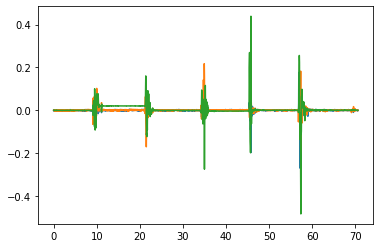

In [13]:
#### Minimal AHRS example, no position estimation

def apply_ahrs(gyro,acc,mag,ts):
    assert len(gyro)==len(acc)
    assert len(acc)==len(mag)
    assert len(mag)==len(ts)
    
    ## Compute the frequency and number of samples
    dt=np.mean(ts[1:]-ts[0:-1])
    freq=1/dt
    num_samples=len(ts)
    
    # Initialize the AHRS filter
    madgwick=ahrs.filters.Madgwick(beta=0.1,frequency=freq)

    # Allocate arrays
    # Initial orientation is set as the reference
    QMARG= np.tile([1.,0.,0.,0.],(num_samples,1))
    QIMU= np.tile([1.,0.,0.,0.],(num_samples,1))
    ACC_LAB=np.zeros((num_samples,3))
    
    ## Measured value of local gravity 9.799 m/s^2
    g=np.array([0,0,0.5])
    
    # For each time step apply the estimation filter
    for t in range(1,num_samples):
    
        # Orientation estimation using madwick filter
        QMARG[t]=madgwick.updateMARG(QMARG[t-1],gyro[t],acc[t],mag[t])
        QIMU[t]=madgwick.updateIMU(QIMU[t-1],gyro[t],acc[t])
        
        #For some reason QIMU is much better than QMARG
        
        #Rotate the acceleration vector from sensor frame to lab frame
        ACC_LAB[t]=Quaternion(QIMU[t]).rotate(acc[t])-g
    return ACC_LAB,QIMU


ACC_LAB,QIMU=apply_ahrs(gyro,acc,mag,ts)
    
## Plot the quaternions from the two different methods
#ahrs.utils.plot_quaternions(QMARG)
#ahrs.utils.plot_quaternions(QIMU)

## Compare the rotated and unrotated acceleration 
#plt.plot(ts,acc[:,0])
#plt.plot(ts,acc[:,1])
#plt.plot(ts,acc[:,2])

plt.plot(ts,ACC_LAB[:,0])
plt.plot(ts,ACC_LAB[:,1])
plt.plot(ts,ACC_LAB[:,2])

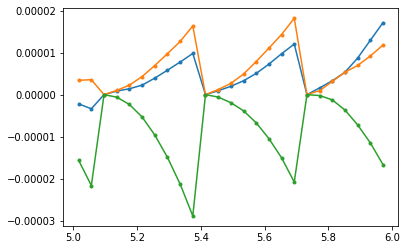

In [16]:
#### Minimal AHRS-Dead reckoning example

def apply_ahrs_position(gyro,acc,mag,ts):
    assert len(gyro)==len(acc)
    assert len(acc)==len(mag)
    assert len(mag)==len(ts)
    
    ## Compute the frequency and number of samples
    dt=np.mean(ts[1:]-ts[0:-1])
    freq=1/dt
    num_samples=len(ts)
    
    # Initialize the AHRS filter
    madgwick=ahrs.filters.Madgwick(beta=0.1,frequency=freq)

    # Allocate arrays
    # Initial orientation is set as the reference
    QMARG= np.tile([1.,0.,0.,0.],(num_samples,1))
    QIMU= np.tile([1.,0.,0.,0.],(num_samples,1))
    ACC_LAB=np.zeros((num_samples,3))
    # state[t]= (x,y,z,vx,vy,vz)
    state=np.zeros((num_samples,6))
    
    ## Measured value of local gravity 9.799 m/s^2
    g=np.array([0,0,0.5])
    
    ## Process transition matrix
    ## x=x0 + v0 dt + 1/2 (a-g) dt^2
    A=np.matrix(\
    [\
    [1,  0,  0,  dt,  0,  0  ] ,\
    [0,  1,  0,  0,  dt,  0  ] ,\
    [0,  0,  1,  0,  0,  dt  ] ,\
    [0,  0,  0,  1,  0,  0   ] ,\
    [0,  0,  0,  0,  1,  0   ] ,\
    [0,  0,  0,  0,  0,  1   ] ,\
    ]\
    )
    ## Control matrix
    B=np.matrix(\
    [\
    [dt**2/2,  0,    0    ] ,\
    [0,    dt**2/2,  0    ] ,\
    [0,        0,  dt**2/2] ,\
    [dt,       0,    0    ] ,\
    [0,       dt,    0    ] ,\
    [0,        0,    dt   ] ,\
    ]\
    )
    
    ## set the interval between zeroing the state
    zero_period=0.300
    next_zero=zero_period


    
    # For each time step apply the estimation filter
    for t in range(1,num_samples):
    
        # Orientation estimation using madwick filter
        QMARG[t]=madgwick.updateMARG(QMARG[t-1],gyro[t],acc[t],mag[t])
        QIMU[t]=madgwick.updateIMU(QIMU[t-1],gyro[t],acc[t])
        
        #For some reason QIMU is much better than QMARG
        
        #Rotate the acceleration vector from sensor frame to lab frame
        ACC_LAB[t]=Quaternion(QIMU[t]).rotate(acc[t])-g
        
        #Update the state using the process and control matrices
        state[t]=A.dot(state[t-1])+B.dot(ACC_LAB[t-1])
        
        
        ## Periodically re-zero the state
        ## This is for inspecting the short-term performance
        if ts[t] > next_zero:
            state[t]=np.zeros(6)
            next_zero=ts[t]+zero_period
    return state,ACC_LAB,QIMU


state,ACC_LAB,QIMU=apply_ahrs_position(gyro,acc,mag,ts)
    
## Inspect the dead-reckoning position estimate
tmax=6
tmin=5
mask=(ts<tmax) & (ts>tmin)
plt.plot(ts[mask],state[mask,0],marker=".")
plt.plot(ts[mask],state[mask,1],marker=".")
plt.plot(ts[mask],state[mask,2],marker=".")